In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pickle
import joblib as jl
import pandas as pd
import os
import gc
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.test.gpu_device_name()
tf.device('/GPU:0')

import multiprocessing
cores=multiprocessing.cpu_count()-2

from itertools import product

2024-12-18 19:43:09.011567: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-18 19:43:12.398125: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-18 19:43:12.703014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 19:43:12.703066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.035GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2024-12-18 19:43:12.703085: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-18 19:43:12.717355: I tensorflo

In [2]:
#configuring matplotlib plots
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

#setting up MNIST
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 58 #image dimensions

(x_train_in, y_train_in), (x_test_in, y_test_in) = mnist.load_data()

x_train_in = x_train_in.astype('float32')
x_train_in /= 255.0
x_train_in = x_train_in.reshape(x_train_in.shape[0], -1)

x_test_in = x_test_in.astype('float32')
x_test_in /= 255.0
x_test_in = x_test_in.reshape(x_test_in.shape[0], -1)

In [3]:
def jl_pairs(i, j, pairs_per_combination, X, Y):
    """
    Generates digit pairs images and labels. Also returns the digit images and labels. To be run in parallell.
    """

    idxl1 = np.where(Y == i)[0]
    idxl2 = np.where(Y == j)[0]

    imgs = []
    x1 = []
    x2 = []
    labels = []
    l1 = []
    l2 = []
            
    for k in range(pairs_per_combination):
        idx1 = np.random.choice(idxl1, replace=False)
        idx2 = np.random.choice(idxl2, replace=False)
        combined_img = np.hstack((X[idx1], X[idx2]))
        combined_label = i+j
        imgs.append(combined_img)
        labels.append(combined_label)
        l1.append(i)
        l2.append(j)
        x1.append(X[idx1])
        x2.append(X[idx2])

    return imgs, labels, x1, x2, l1, l2

def random_sampling(X, Y, pairs_per_label, output):
    """
    For when the number of output samples is less than 100 and cannot have even permutation pair representation.
    """
    imgs = []
    x1 = []
    x2 = []
    labels = []
    l1 = []
    l2 = []
    count = 0

    #list of all possible permutations of digit pairs
    all_pairs = np.array(list(product(range(10), repeat=2)))

    while count < output:
        #randomly pick from this list without replacement
        label_idx = np.random.choice(len(all_pairs), replace=False)

        #get 'left' and 'right' digits
        i = all_pairs[label_idx][0]
        j = all_pairs[label_idx][1]
        label = i + j

        # list of all possible images of 'left' and 'right' digits
        idxl1 = np.where(Y == i)[0]
        idxl2 = np.where(Y == j)[0]

        #choose without replacement from this list
        idx1 = np.random.choice(idxl1, replace=False)
        idx2 = np.random.choice(idxl2, replace=False)

        #create pair
        combined_img = np.hstack((X[idx1], X[idx2]))

        #append to lists
        imgs.append(combined_img)
        labels.append(label)
        l1.append(i)
        l2.append(j)
        x1.append(X[idx1])
        x2.append(X[idx2])
        count += 1
    
    return imgs, labels, x1, x2, l1, l2

def jl_dataset(X, Y, output=100000, n_jobs=cores):

    """
    Calls upon jl_pairs to generate output image and label pairs along with digit images and labels if output >= 100. Else, calls upon random_sampling. Shuffles them so they are randomised.
    """

    imgs = []
    labels = []
    l1 = []
    l2 = []
    x1 = []
    x2 = []

    if output >= 100:
        pairs_per_combination = output//100  
        results = jl.Parallel(n_jobs=n_jobs)(jl.delayed(jl_pairs)(i, j, pairs_per_combination, X, Y) for i in range(10) for j in range(10))

        for ri, rl, rx1, rx2, rl1, rl2 in results:
            imgs.extend(ri)
            labels.extend(rl)
            l1.extend(rl1)
            l2.extend(rl2)
            x1.extend(rx1)
            x2.extend(rx2)
    else:
        pairs_per_label = output//19
        
        ri, rl, rx1, rx2, rl1, rl2 = random_sampling(X, Y, pairs_per_label, output)
        imgs.extend(ri)
        labels.extend(rl)
        l1.extend(rl1)
        l2.extend(rl2)
        x1.extend(rx1)
        x2.extend(rx2)

    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]
    x1 = np.array(x1)[shuffle_idx]
    x2 = np.array(x2)[shuffle_idx]

    return imgs, labels, l1, l2, x1, x2

In [4]:
def get_data(output=100000):
    """
    Shuffles input training and testing data. 
    Calls upon jl_dataset for training, and testing datasets. 
    Returns the training and testing datasets.
    """
    train_shuffle_idx = np.random.permutation(len(x_train_in))
    x_train = x_train_in[train_shuffle_idx]
    y_train = y_train_in[train_shuffle_idx]
    
    test_shuffle_idx = np.random.permutation(len(x_test_in))
    x_test = x_test_in[test_shuffle_idx]
    y_test = y_test_in[test_shuffle_idx]

    x_train, y_train, y1_train, y2_train, x1_train, x2_train = jl_dataset(x_train, y_train, output=output)
    
    x_test, y_test, y1_test, y2_test, x1_test, x2_test = jl_dataset(x_test, y_test, output=output)

    return x_train, y_train, x_test, y_test, x1_train, y1_train, x2_train, y2_train, x1_test, y1_test, x2_test, y2_test

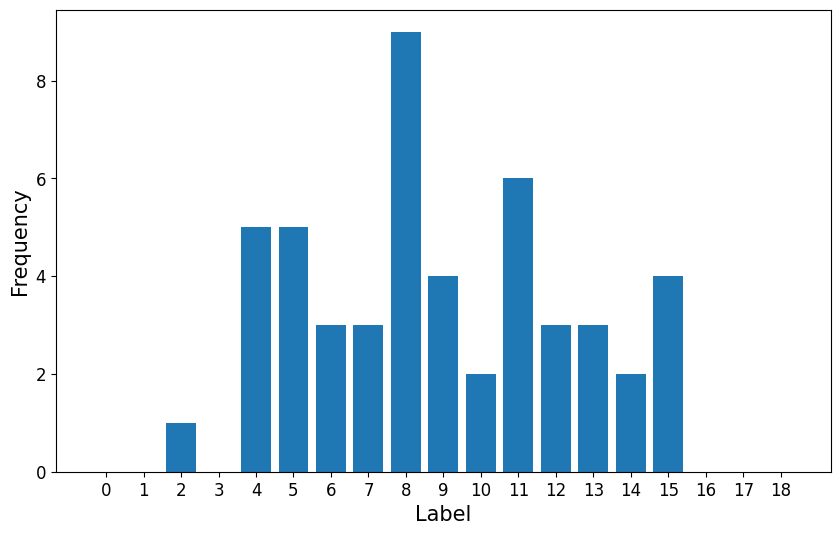

In [ ]:
np.random.seed(21)
def show_plot():
    """
    Shows label distribution for dataset of 50 samples.
    """
    x_train, y_train = get_data(output=50)[:2]
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(y_train, bins=np.arange(20) - 0.5, rwidth=0.8)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(19))  # Labels from 0 to 18
    fig.savefig('Y_dist_few.png')
    plt.show()

show_plot()

In [6]:
def training_models():
    """
    Generates model accuracies, classification reports, confusion matrices, class probabilities, and predictions for linear regression classifers trained and applied on the entire image and linear regression classifiers applied sequentially.
    Also returns testing and training data.
    Also returns class probabilities for 'left' and 'right' digits.
    """
    sizes = [50, 100, 500, 1000, 10000]
    accuracies = {}
    classifications = {}
    confusions = {}
    probabilities = {}
    probs = {}
    predictions = {}
    tests={}
    trains = {}
    for i, size in enumerate(sizes):
        x_train, y_train, x_test, y_test, x1_train, y1_train, x2_train, y2_train, x1_test, y1_test, x2_test, y2_test = get_data(output=size)

        single_model = LogisticRegression(max_iter=1000)
        single_model.fit(x_train, y_train)
        
        single_probability = single_model.predict_proba(x_test)
        single_predictions = single_model.predict(x_test)
        
        if size < 100: 
            values, edges = np.histogram(y_train, bins=np.arange(20))
            centers = np.array([int(p) for p in np.floor(0.5*(edges[1:]+edges[:-1]))])
            mask = np.where(values != 0)[0]
            new_centers = centers[mask]
            single_prob = np.zeros(shape=(len(single_probability), 19))
            for l in range(len(single_probability)):
                for m, j in enumerate(new_centers):
                    single_prob[l, j] = single_probability[l, m]

            single_probability = single_prob

        single_accuracy = accuracy_score(y_true=y_test, y_pred=single_predictions)
        single_classification = classification_report(y_true=y_test, y_pred=single_predictions, zero_division=0)
        single_confusion = confusion_matrix(y_true=y_test, y_pred=single_predictions)

        seq_model = LogisticRegression(max_iter=1000)

        seq_model.fit(x1_train, y1_train)
        
        pred1 = seq_model.predict(x1_test)
        pred2 = seq_model.predict(x2_test)

        seq_predictions = pred1+pred2
        seq_truth = y1_test + y2_test

        prob1 = seq_model.predict_proba(x1_test)
        prob2 = seq_model.predict_proba(x2_test)
        
        seq_probability = np.zeros(shape=(len(prob1), 19))
        for l in range(len(prob1)):
            for p in range(19):
                seq_probability[l, p] = sum(prob1[l, j]*prob2[l, k] for j in range(10) for k in range(10) if j+k == p)
    
        seq_accuracy = accuracy_score(y_true=seq_truth, y_pred=seq_predictions)
        seq_classification = classification_report(y_true=seq_truth, y_pred=seq_predictions, zero_division=0)
        seq_confusion = confusion_matrix(y_true=seq_truth, y_pred=seq_predictions)

        predictions[(i, 0)] = seq_predictions
        predictions[(i, 1)] = single_predictions
        probs[(i, 0)] = prob1
        probs[(i, 1)] = prob2
        probabilities[(i, 0)] = seq_probability
        probabilities[(i, 1)] = single_probability
        accuracies[(i, 0)] = seq_accuracy
        accuracies[(i, 1)] = single_accuracy
        classifications[(i, 0)] = seq_classification
        classifications[(i, 1)] = single_classification
        confusions[(i, 0)] = seq_confusion
        confusions[(i, 1)] = single_confusion
        tests[(i, 0)] = x_test
        tests[(i, 1)] = y_test
        trains[(i, 0)] = x_train
        trains[(i, 1)] = y_train
        
    return probs, probabilities, accuracies, classifications, confusions, predictions, tests, trains

np.random.seed(441)
probs, probabilities, accuracies, classifications, confusions, predictions, tests, trains = training_models()

In [7]:
#format accuracies into a table
dataframe = pd.DataFrame(data={'size': [50, 100, 500, 1000, 10000], 'single accuracies': [accuracies[(0,1)], accuracies[(1,1)], accuracies[(2,1)], accuracies[(3,1)], accuracies[(4,1)]],'sequential accuracies': [accuracies[(0,0)], accuracies[(1,0)], accuracies[(2,0)], accuracies[(3,0)], accuracies[(4,0)]]})
display(dataframe)

,size,single accuracies,sequential accuracies
0,50,0.0800,0.3600
1,100,0.1000,0.7100
2,500,0.1100,0.7340
3,1000,0.1360,0.7520
4,10000,0.1775,0.8155


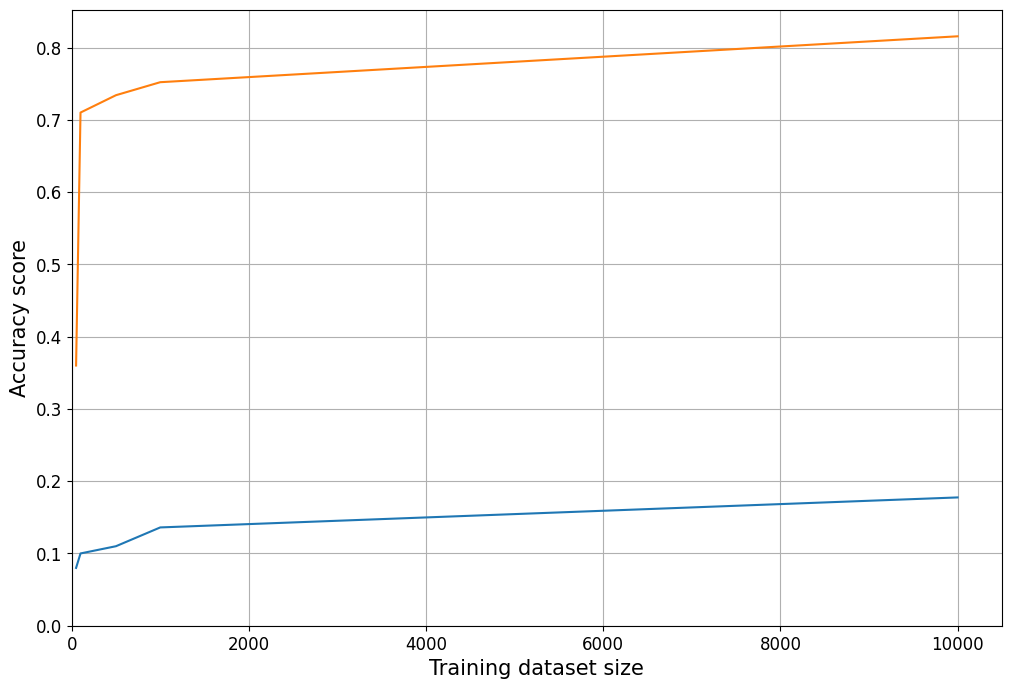

In [8]:
def compare_plot(accuracies):
    """
    Plots accuracies of single and sequential linear regression classifiers as a function of dataset size.
    """
    sizes = [50, 100, 500, 1000, 10000]
    single_accuracies = [accuracies[(i, 1)] for i in range(len(sizes))]
    seq_accuracies = [accuracies[(i, 0)] for i in range(len(sizes))]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(sizes, single_accuracies, label="Single linear classifier")
    ax.plot(sizes, seq_accuracies, label="Sequential linear classifiers")
    ax.set_xlabel("Training dataset size")
    ax.set_ylabel("Accuracy score")
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    plt.grid()
    plt.savefig("classifier_compare.png")
    plt.show()
    

compare_plot(accuracies)

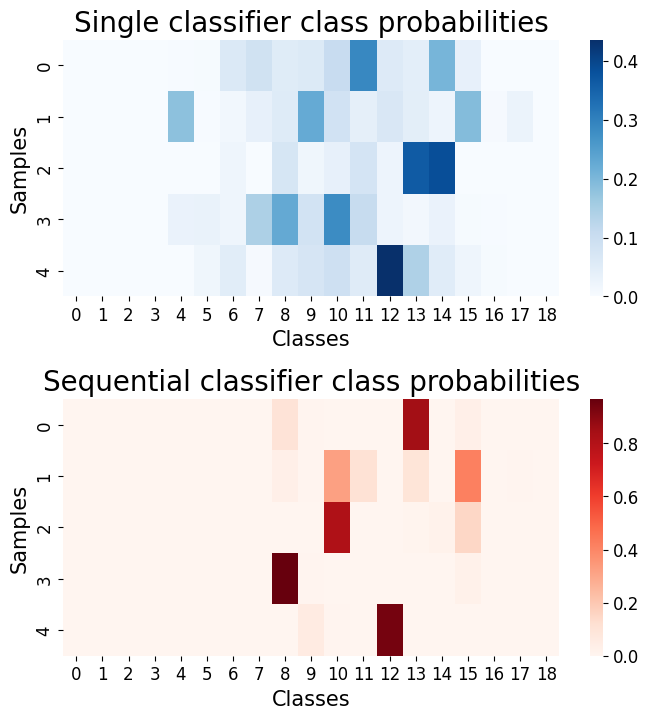

In [9]:
def plot_probs(probabilities):
    """
    Plots heatmaps of the first five linear regression class probabilities for the single and sequential linear classifiers.
    Specifically, for dataset size = 10,000.
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    sns.heatmap(probabilities[(4, 1)][:5], cmap='Blues', annot=False, xticklabels=range(19), yticklabels=range(5), ax=ax[0])
    ax[0].set_xlabel('Classes')
    ax[0].set_ylabel('Samples')
    ax[0].set_title('Single classifier class probabilities', fontsize=20)

    sns.heatmap(probabilities[(4, 0)][:5], cmap='Reds', annot=False, xticklabels=range(19), yticklabels=range(5), ax=ax[1])
    ax[1].set_xlabel('Classes')
    ax[1].set_ylabel('Samples')
    ax[1].set_title('Sequential classifier class probabilities', fontsize=20)

    plt.subplots_adjust(hspace=0.4)

    plt.savefig("classifier_heatmap.png")
    plt.show()

plot_probs(probabilities)

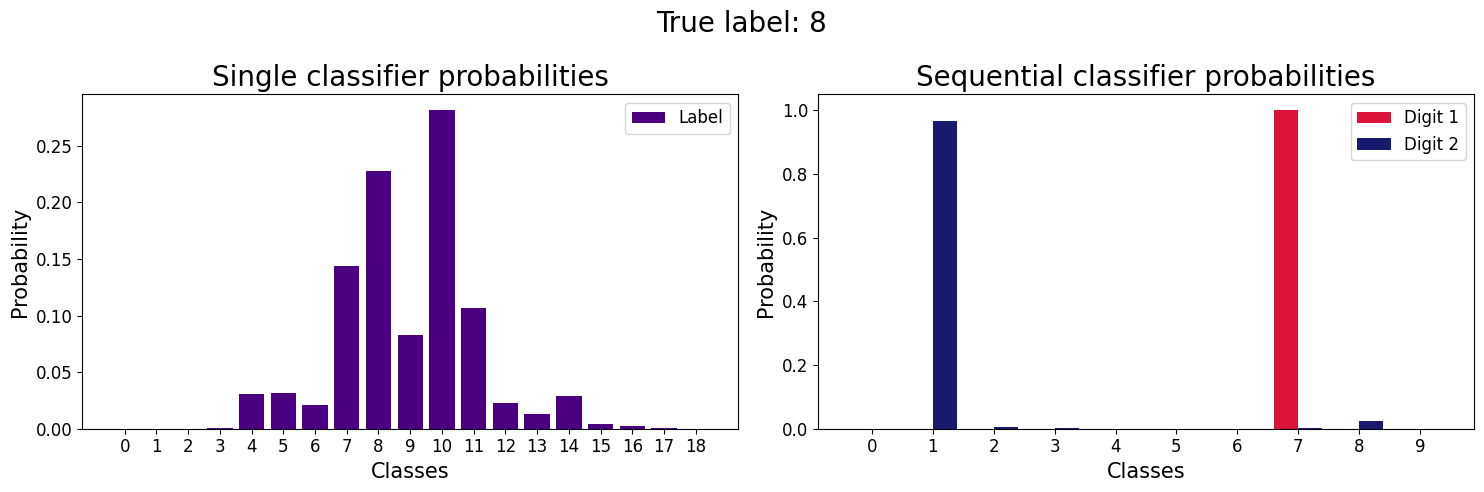

In [11]:
def plot_probs2(probabilities, probs, tests):
    """
    Plots the class probabilities of one sample, using the single linear regression classifier class probabilities and the separate sequential linear regression classifier class probabilities.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    idx = 3
    ax[0].bar(range(19), probabilities[(4, 1)][idx], color='indigo', label='Label')
    ax[0].set_title("Single classifier probabilities", fontsize=20)
    ax[0].set_xlabel("Classes")
    ax[0].set_ylabel("Probability")
    ax[0].set_xticks(range(19))
    ax[0].legend()

    x = np.arange(10)
    ax[1].bar(x - 0.2, probs[(4, 0)][idx], width=0.4, label='Digit 1', color='crimson')
    ax[1].bar(x + 0.2, probs[(4, 1)][idx], width=0.4, label='Digit 2', color='midnightblue')
    ax[1].set_title("Sequential classifier probabilities", fontsize=20)
    ax[1].set_xlabel("Classes")
    ax[1].set_ylabel("Probability")
    ax[1].set_xticks(range(10))
    ax[1].legend()
    
    plt.suptitle(f"True label: {tests[(4, 1)][idx]}")
    plt.tight_layout()
    plt.savefig("classifer_barplot.png")
    plt.show()

plot_probs2(probabilities, probs, tests)